# 【課題】 Car Fuel Consumption

 ### 目的
 - ガスの種類に応じて車の燃料消費を予測する線形回帰モデルを作成する

In [109]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge,Lasso,ElasticNet
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## DAY1で学んだこと
- データの可視化
- 線形回帰モデルの作成
- モデルの評価指標 (MSE,RMSE,MAE)

###  1.  データの可視化

In [3]:
# データ読込
df_cfc = pd.read_csv("./measurements2.csv")
display(df_cfc.head())
df_cfc.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters
count,388.000000,388.000000,388.000000,376.000000,388.000000,388.000000,388.000000,388.000000,13.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.077320,0.123711,0.082474,37.115385
std,22.667837,1.033172,13.598524,1.010455,6.991542,0.267443,0.329677,0.275441,8.587282
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,10.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,37.600000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,0.000000,0.000000,0.000000,38.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,0.000000,0.000000,0.000000,39.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,45.000000


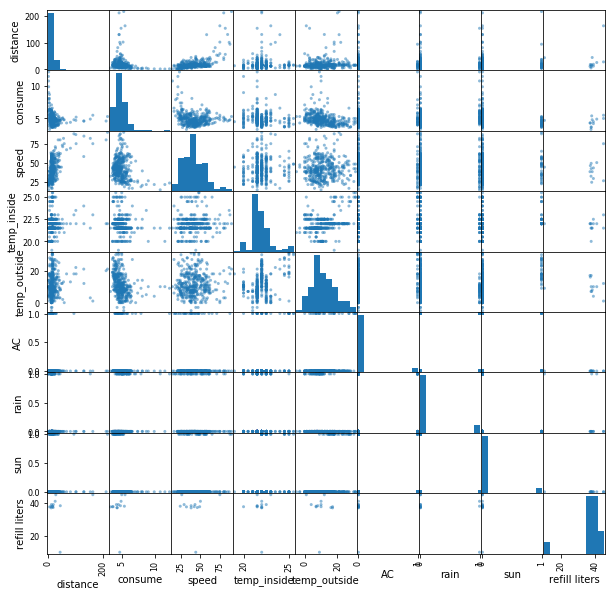

In [10]:
#散布図
pd.plotting.scatter_matrix(df_cfc, figsize=(10,10))
plt.show()

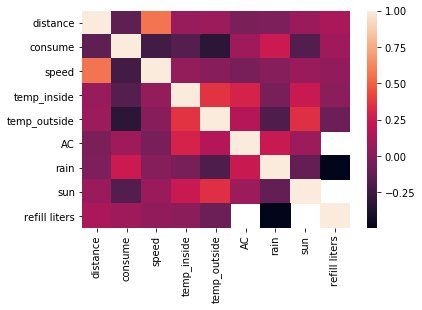

In [8]:
# 相関係数
df_cfc.corr()
sns.heatmap(df_cfc.corr())
plt.show()

In [9]:
# 目的変数の欠損値有無
print(df_cfc.consume.isnull().any())

False


In [21]:
# 欠損値補完：temp_insideの欠損値を平均値で保管
df_cfc['temp_inside'] = df_cfc['temp_inside'].fillna(df_cfc['temp_inside'].mean())

In [22]:
df_cfc.count()

distance         388
consume          388
speed            388
temp_inside      388
temp_outside     388
specials          93
gas_type         388
AC               388
rain             388
sun              388
refill liters     13
refill gas        13
dtype: int64

対象となるデータは、自動車の走行データで各項目のデータの意味は以下のとおりと考えられる。

データレコード：388

- distance【数値データ】走行距離
- consume【数値データ】ガソリン消費量（目的変数）
- speed【数値データ】走行中の平均速度
- temp_inside【数値データ】車内の気温
- temp_outside【数値データ】車外の気温
- specials【文字データ】特殊気候条件（AC、Rain、sun）
- gas_type【文字データ】ガソリンの種類
- AC【文字データ】？？？
- rain【文字データ】天候が雨であったかを示すフラグ
- sun【文字データ】天候が雨であったかを示すフラグ
- refill liters【数値データ】ガソリンの補給量
- refill gas【文字データ】補給量したガソリンの種類

### 2.モデルの作成と評価

- 上記データのうち、まずは単純にデータ量が十分にある数値データ（refill liters以外の数値データ）を対象として、線形モデルを作成してみる
- モデルの評価指標は、MAE(平均二乗誤差)を用いる

In [27]:
X = df_cfc[['distance', 'speed', 'temp_outside', 'temp_inside','AC','rain','sun']].values
y = df_cfc["consume"].values

regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

y_pred = regr.predict(X)

mae = mean_absolute_error(y, y_pred)
print("MAE = %s"%round(mae,3) )

MAE = 0.619


### 考察
- 目的変数の値(mean：4.9)に対して誤差0.6。改善の余地があると考える
- そもそもの問題としてはガスの種類に応じてガソリンの消費量を予測することなので、gas_typeのデータを説明変数に用いる必要がある

## DAY2で学んだこと
- データの前処理（正規化、正則化）
- 訓練誤差と汎化誤差
- SVM

### 1. データの前処理

In [95]:
# gas_typeからダミー変数E10とSP98を作成
df_dummy = pd.get_dummies(df_cfc['gas_type'])
df_cfc = pd.concat([df_cfc, df_dummy], axis=1)
display(df_cfc.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,distance_norm,speed_norm,temp_inside_norm,temp_outside_norm,E10,SP98
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,0.124302,0.157895,0.384615,0.472222,1,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,0.049814,0.210526,0.384615,0.500000,1,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.046089,0.315789,0.384615,0.555556,1,0
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN,0.054004,0.289474,0.384615,0.527778,1,0
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.080074,0.421053,0.384615,0.555556,1,0


### 正規化
- 実数値を対象に正規化　distance, speed, temp_inside, temp_outside
- 他の0/1値を持つ説明変数とあわせるため、標準化より0-1にスケールする正規化が適していると考える

In [29]:
# 正規化
df_cfc["distance_norm"] = (df_cfc["distance"] - df_cfc["distance"].min()) / (df_cfc["distance"].max() - df_cfc["distance"].min())
df_cfc["speed_norm"] = (df_cfc["speed"] - df_cfc["speed"].min()) / (df_cfc["speed"].max() - df_cfc["speed"].min())
df_cfc["temp_inside_norm"] = (df_cfc["temp_inside"] - df_cfc["temp_inside"].min()) / (df_cfc["temp_inside"].max() - df_cfc["temp_inside"].min())
df_cfc["temp_outside_norm"] = (df_cfc["temp_outside"] - df_cfc["temp_outside"].min()) / (df_cfc["temp_outside"].max() - df_cfc["temp_outside"].min())
display(df_cfc.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,E10,SP98,E10,SP98,distance_norm,speed_norm,temp_inside_norm,temp_outside_norm
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,1,0,1,0,0.124302,0.157895,0.384615,0.472222
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,1,0,1,0,0.049814,0.210526,0.384615,0.500000
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,1,0,1,0,0.046089,0.315789,0.384615,0.555556
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN,1,0,1,0,0.054004,0.289474,0.384615,0.527778
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN,1,0,1,0,0.080074,0.421053,0.384615,0.555556


### 2.モデルの作成と評価

- 'refill liters', 'refill gas' はデータ不足により説明変数から除外する
- 'specials' は'AC', 'rain', 'sun' で表現されているため説明変数から除外する
- 'gas_type' からダミー変数を生成(E10, SP98)に説明変数に用いる
- ホールドアウト法及び交差検証を用い、訓練誤差と汎化誤差をそれぞれ評価する

### ホールドアウト
- 学習データを全データの80% テストデータを全データの20%とする

In [45]:
X = df_cfc[['distance_norm', 'speed_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun', 'E10' , 'SP98']].values
y = df_cfc["consume"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [47]:
#訓練誤差
y_pred_train = regr.predict(X_train)

mae = mean_absolute_error(y_train, y_pred_train)
print("MAE = %s"%round(mae,3) )

MAE = 0.578


In [48]:
#汎化誤差
y_pred_test = regr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

MAE = 0.696


### 交差検証
 - 訓練データ(全体の80%)を学習用とテスト用に10分割

In [33]:
n_split = 10 
cross_valid_mae = 0
split_num = 1

#X_train、y_trainをさらに学習用とテスト用に分割
for train_idx, test_idx in KFold(n_splits=n_split, random_state=1234).split(X_train, y_train):
    X_train_t, y_train_t = X_train[train_idx], y_train[train_idx] #学習用データ
    X_test_t, y_test_t = X_train[test_idx], y_train[test_idx]     #テスト用データ
    
    regr = LinearRegression(fit_intercept=False)
    regr.fit(X_train_t,y_train_t)

    y_pred_test_t = regr.predict(X_test_t)
    mae = mean_absolute_error(y_test_t, y_pred_test_t)

    cross_valid_mae += mae
    split_num += 1

final_mae = cross_valid_mae / n_split
print("Cross Validation MAE = %s"%round(final_mae, 3))

Cross Validation MAE = 0.597


In [34]:
y_pred_test = regr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
print("MAE = %s"%round(mae,3) )

MAE = 0.697


### 考察
- 訓練誤差についてはデータに対する前処理を行うことで、多少の低減は見られたので、正規化の効果は出ていると考える。
- ただ汎化誤差を計測してみると、MAE=0.69と高い。モデルの評価としてはこちらを低減することを考えていく。
- ホールドアウト法と交差検証で比較した結果、特に誤差に有意的な差は見られないので、ホールドアウト（訓練データ80%、テストデータ20%）の配分は適切であると考えられる。以降の検証は、ホールドアウト（訓練データ80%、テストデータ20%）で汎化性能の評価指標でモデルを検証していく

### TODO
- 正則化項を追加し、汎化誤差の低減

## DAY3で学んだこと
- データの前処理（特徴選択）

### 1. データの前処理

In [42]:
#相関件数
df_cfc.corr()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,refill liters,E10,SP98,E10,SP98,distance_norm,speed_norm,temp_inside_norm,temp_outside_norm
distance,1.000000,-0.128967,0.562299,0.075178,0.088175,-0.025738,-0.019791,0.081120,0.132852,0.053411,-0.053411,0.053411,-0.053411,1.000000,0.562299,0.075178,0.088175
consume,-0.128967,1.000000,-0.227866,-0.160623,-0.320811,0.096591,0.248118,-0.170667,0.100868,0.015327,-0.015327,0.015327,-0.015327,-0.128967,-0.227866,-0.160623,-0.320811
speed,0.562299,-0.227866,1.000000,0.059293,0.015411,-0.035408,0.009489,0.081618,0.049673,0.097360,-0.097360,0.097360,-0.097360,0.562299,1.000000,0.059293,0.015411
temp_inside,0.075178,-0.160623,0.059293,1.000000,0.359500,0.297376,-0.036937,0.242248,0.034128,-0.010198,0.010198,-0.010198,0.010198,0.075178,0.059293,1.000000,0.359500
temp_outside,0.088175,-0.320811,0.015411,0.359500,1.000000,0.167562,-0.186315,0.346903,-0.084867,-0.148705,0.148705,-0.148705,0.148705,0.088175,0.015411,0.359500,1.000000
AC,-0.025738,0.096591,-0.035408,0.297376,0.167562,1.000000,0.242915,0.088598,NaN,-0.105285,0.105285,-0.105285,0.105285,-0.025738,-0.035408,0.297376,0.167562
rain,-0.019791,0.248118,0.009489,-0.036937,-0.186315,0.242915,1.000000,-0.112650,-0.494501,-0.060328,0.060328,-0.060328,0.060328,-0.019791,0.009489,-0.036937,-0.186315
sun,0.081120,-0.170667,0.081618,0.242248,0.346903,0.088598,-0.112650,1.000000,NaN,-0.022761,0.022761,-0.022761,0.022761,0.081120,0.081618,0.242248,0.346903
refill liters,0.132852,0.100868,0.049673,0.034128,-0.084867,NaN,-0.494501,NaN,1.000000,0.238081,-0.238081,0.238081,-0.238081,0.132852,0.049673,0.034128,-0.084867
E10,0.053411,0.015327,0.097360,-0.010198,-0.148705,-0.105285,-0.060328,-0.022761,0.238081,1.000000,-1.000000,1.000000,-1.000000,0.053411,0.097360,-0.010198,-0.148705


### フィルタ法
- 相関が比較的高いdistanceとspeedについて、それぞれ説明変数から除いてみる

In [57]:
#speedを除外
X = df_cfc[['distance_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun', 'E10' , 'SP98']].values
y = df_cfc["consume"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

#訓練誤差
y_pred_train = regr.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("train_MAE = %s"%round(mae,3) )
#汎化誤差
y_pred_test = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("test_MAE = %s"%round(mae,3) )

train_MAE = 0.573
test_MAE = 0.703


In [58]:
#distanceを除外
X = df_cfc[['speed_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun', 'E10' , 'SP98']].values
y = df_cfc["consume"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

#訓練誤差
y_pred_train = regr.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("train_MAE = %s"%round(mae,3) )
#汎化誤差
y_pred_test = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("test_MAE = %s"%round(mae,3) )

train_MAE = 0.578
test_MAE = 0.696


### ラッパー法
- LASSO
- ステップワイズ

In [96]:
display(df_cfc.head())

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas,distance_norm,speed_norm,temp_inside_norm,temp_outside_norm,E10,SP98
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45.0,E10,0.124302,0.157895,0.384615,0.472222,1,0
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN,0.049814,0.210526,0.384615,0.500000,1,0
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.046089,0.315789,0.384615,0.555556,1,0
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN,0.054004,0.289474,0.384615,0.527778,1,0
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN,0.080074,0.421053,0.384615,0.555556,1,0


In [97]:
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)

#drop_idx = ['consume', 'specials','gas_type','refill liters','refill gas']

train_label = df_cfc["consume"]
train_data = df_cfc[['distance_norm', 'speed_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun', 'E10' , 'SP98']]

y = train_label.values
X = train_data.values

print(X)

sfm.fit(X, y)

[[0.12430168 0.15789474 0.38461538 ... 0.         1.         0.        ]
 [0.04981378 0.21052632 0.38461538 ... 0.         1.         0.        ]
 [0.04608939 0.31578947 0.38461538 ... 0.         1.         0.        ]
 ...
 [0.06843575 0.40789474 0.92307692 ... 0.         0.         1.        ]
 [0.06564246 0.36842105 0.92307692 ... 0.         0.         1.        ]
 [0.06238361 0.14473684 0.92307692 ... 0.         0.         1.        ]]


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False),
        norm_order=1, prefit=False, threshold=1e-05)

In [98]:
sfm.get_support()

array([False,  True,  True,  True,  True,  True,  True, False, False])

In [99]:
removed_idx  = ~sfm.get_support()
train_data.columns[removed_idx]

Index(['distance_norm', 'E10', 'SP98'], dtype='object')

In [100]:
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.        , 1.05527097, 0.24410686, 1.31876706, 0.27484597,
       0.45941577, 0.0521433 , 0.        , 0.        ])

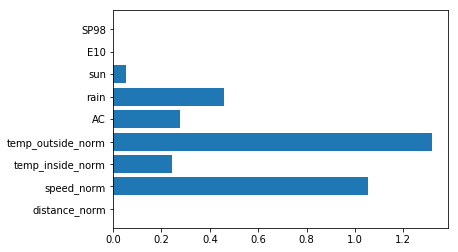

In [101]:
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=train_data.columns.values)
plt.show()

### 2.モデルの作成と評価
- LASSOで特徴選択した結果、予測値に寄与している変数のみでモデル化

In [103]:
X = df_cfc[['speed_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun']].values
y = df_cfc["consume"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

#訓練誤差
y_pred_train = regr.predict(X_train)
mae = mean_absolute_error(y_train, y_pred_train)
print("train_MAE = %s"%round(mae,3) )
#汎化誤差
y_pred_test = regr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_test)
print("test_MAE = %s"%round(mae,3) )

train_MAE = 0.578
test_MAE = 0.697


### 考察
- 汎化誤差の改善が見られない
- 別の方法を検討

In [108]:
### ステップワイズ
estimator = LinearRegression(normalize=True)
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

data = df_cfc["consume"]
label = df_cfc[['distance_norm', 'speed_norm', 'temp_inside_norm', 'temp_outside_norm', 'AC', 'rain', 'sun', 'E10' , 'SP98']]

train_data, test_data, train_label, test_label = train_test_split(data, label, test_size=0.2, random_state=0)

X_train = train_data.values
y_train = train_label.values
X_test = test_data.values
y_test = test_label.values

rfecv.fit(X_train, y_train)
y_pred = rfecv.predict(X_test)

mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

ValueError: Expected 2D array, got 1D array instead:
array=[ 3.9  4.9  6.4  4.3  6.   4.   4.2  4.2  4.8  5.3  4.8  4.3  4.9  4.5
  4.5  4.5  5.   5.6  6.1  5.9  3.9  7.1  4.9  4.7  4.4  4.5  4.   4.7
  4.5  5.5  4.4  4.   5.7  5.   4.9  5.   5.2  5.3  5.2  4.6  4.4  5.
  5.9  5.8  4.4  4.5  5.2  7.4  5.1  5.3  4.   5.   5.3  4.7  4.3  6.9
  4.8  5.1  4.9  5.1  5.3  5.1  4.7  4.5  4.5  6.   5.6  5.5  3.8  4.2
  5.2  4.5  4.8  4.1  4.3  4.8  5.3  6.2  4.4  3.7  4.   3.8  4.4  4.7
  4.7  5.1  4.   5.3  4.5  3.9  4.5  4.5  4.3  4.3  5.7  5.1  4.9  4.7
  4.   5.8  5.5  5.6  4.7  6.1  3.9  3.8  6.1  4.4  3.7  3.9  4.5  4.6
  5.7  4.5  4.   5.9  3.7  3.3  4.   4.3  4.7  5.4  4.8  3.8  5.6  3.7
  4.9  4.1  4.   5.7  6.2  6.2  3.9  3.9  6.6  5.   8.1  5.4  4.8  5.2
  4.6  3.8  4.6  4.6  4.4  3.6  4.3  5.7  4.8  4.2  4.6  5.6  5.   5.4
  5.1  4.9  4.7  4.5  5.4  3.7  4.5  4.2  4.7 12.2  5.   5.4  4.3  4.1
  4.3  4.1  4.2  4.7  4.1  4.   8.7  5.1  6.5  4.6  4.1  3.9  6.3  5.1
  5.1  4.9  5.   4.6  5.2  5.1  5.4  6.   4.6  4.1  4.3  4.   5.2  3.6
  4.2  5.   3.8  5.1  3.7  5.3  3.9  3.6  5.6  5.2  5.8  4.6  5.7  4.8
  4.7  4.3  5.   3.8  5.1  5.7  3.7  4.8  5.   5.9  5.   5.3  4.1  4.8
  4.5  4.9  6.3  4.5  5.1  4.7  5.2  4.9  6.4  4.   4.6  4.5  4.1  4.9
  5.8  4.9  4.3  5.8  3.6  4.   5.8  5.6  6.2  4.2  4.7  3.8  4.6  5.3
  4.8  3.8  4.8  6.1  4.2  5.6  4.1  5.5  4.7  4.4  5.   5.9  4.5  5.
  5.6  4.3  5.   4.8  5.   4.8 10.8  4.3  5.   5.3  4.4  4.2  3.8  4.6
  5.8  6.3  3.9  5.1  4.7  4.1  6.3  3.7  3.9  4.9  4.   6.5  4.8  5.3
  5.1  5.2  5.   4.1  5.7  4.4  5.   5.3  4.2  4.5  4.4  4.   4.2  6.
  4.9  4.4].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.